In [1]:
%matplotlib inline
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import re
import pickle
import pandas as pd
import csv
import os
import time
import datetime
from tensorflow.contrib import learn
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import clear_output, Image, display, HTML

In [2]:
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

In [3]:
"""
    Train/test file separated, use in Supervised Phase
    """
def load_data_and_labels(train_data_file, test_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    train_data = pd.read_csv(train_data_file, sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['id', 'language', 'label', 'text'])
    test_data = pd.read_csv(test_data_file, sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['id', 'language', 'label', 'text'])

    x_train = train_data['text'].tolist()
    y_train = train_data['label'].tolist()

    x_test = test_data['text'].tolist()
    y_test = test_data['label'].tolist()
    
    x_train = [s.strip() for s in x_train]
    x_test = [s.strip() for s in x_test]
    
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    
    y_train_encoding = [label_encoding[label] for label in y_train]    
    y_test_encoding = [label_encoding[label] for label in y_test]

    return [x_train, y_train_encoding, x_test, y_test_encoding]

"""Load file without using pandas
"""
def load_without_pandas(paths, numbers={}):
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    i=0
    X = []
    y = []
    for path in paths:
        try:
            n = numbers[path]
        except KeyError:
            n = 0
        i=0
        with open(path, 'r', encoding='utf8') as f:
            for line in f:
                if n and i >= n:
                    break
                i += 1
                splits = line.split('\t')
                y.append(label_encoding[splits[2]])
                X.append(splits[3].rstrip())
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return [X_train, y_train, X_test, y_test]

"""
    One single data, use in Distance-supervised Phase
    """
def transform_data_and_labels(data):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    
    x = np.array(data['text'].tolist())
    y = data['label'].tolist()
    
    # encoding label
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    y = [label_encoding[label] for label in y]    
    
    
    y = np.array(y)
    
    # Randomly shuffle data
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]

    # Split train/test set
    # maybe we can use cross-validation to improve
    dev_sample_index = -1 * int(0.1 * float(len(y)))
    x_train, x_test = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_test = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
    print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
    
    return [x_train, y_train, x_test, y_test]

"""Tokenize train and test tweets, find the maximum length of tweetm,
    and find all tokens seen in the word dict"""
def tokenize_tweet(train_tweets, test_tweets, word_dict):
    all_tokens = {}
    dropped = 0
    # max_document_length = max([len(x.split(" ")) for x in x_train_sentence])
    ppl_re = re.compile(r'@\S*')
    url_re = re.compile(r'http\S+')
    esc_re = re.compile(r'\\u')
    tknzr = TweetTokenizer()
    # tknzr = TweetTokenizer(reduce_len=True)
    
    tokenized_tweets_all = []
    max_document_length = 0
    dropped = 0
    for tweets in [train_tweets, test_tweets]:
        tweets = [url_re.sub('URLTOK', ppl_re.sub('USRTOK', tweet.lower())) for tweet in tweets]
        tokenized_tweets = []
        for tweet in tweets:
            if len(esc_re.findall(tweet)) > 6:
                dropped += 1
                continue
            tokenized_tweet = tknzr.tokenize(tweet)
            if len(tokenized_tweet) > 65:
                dropped += 1
                continue
            for token in tokenized_tweet:
                if token in word_dict:
                    all_tokens[token] = True
            tokenized_tweets. append(tokenized_tweet)     
        tokenized_tweets_all.append(tokenized_tweets)
        max_document_length = max(max_document_length, max([len(tweet) for tweet in tokenized_tweets]))
    print(max_document_length)
    print("dropped ", dropped)
    return tokenized_tweets_all[0], tokenized_tweets_all[1], all_tokens, max_document_length

"""
    This function assumes that the last word in the word embedding is a zero vector, and will use it as UNKNOWN WORDS.
    Padding will be num_voc, and unknown words will be num_voc-1.
    The input 'num_voc' equals to the shape[0] of the word embedding.
    Also returns all seen tokens for reducing word embedding.
"""
def process_tweet(train_tweets, test_tweets, word_dict, max_document_length):
    x = []
    num_voc = len(word_dict)
    for tokenized_tweets in [train_tweets, test_tweets]:
        x_curr = []
        for tokenized_tweet in tokenized_tweets:
#             if len(tokenized_tweet) == max_document_length:
#                 print(tokenized_tweet)
            """Not sure if original paper does this, but since index 0 means USRTOK, padding should be a number
            higher than total word count, so tf.nn.embedding_lookup will return a tensor of 0 insted of USRTOK."""
        #     temp = np.zeros(max_document_length, dtype=np.int).tolist()
            temp = (np.ones(max_document_length, dtype=np.int)*(num_voc)).tolist()

            for index, word in enumerate(tokenized_tweet):
                if word in word_dict:
#                     temp[index] = word_dict[word][0]
                    temp[index] = word_dict[word]
                else:
                    temp[index] = num_voc-1
            x_curr.append(temp)
        x_curr = np.array(x_curr)
        x.append(x_curr)
    
    return x[0], x[1]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        print("Current epoch: ", epoch)
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            if batch_num == num_batches_per_epoch-1:
                yield shuffled_data[start_index:end_index], True
            else:
                yield shuffled_data[start_index:end_index], False

# Load pre-train word embeddings

In [4]:
# original_embeddings = np.load('./data/embed_tweets_en_590M_52D_data/en_word2vec_52_paper.npy')
original_word_dict = {}
with open('./data/embed_tweets_en_590M_52D_data/vocabulary_dict_52_paper.pickle', 'rb') as myfile:
    original_word_dict = pickle.load(myfile)
original_embeddings = np.load('./data/embed_tweets_en_590M_52D_data/en_word2vec_52_paper.npy.npy')



In [ ]:
print(len(original_word_dict.items()))
print(original_embeddings.shape)

# Distant Supervision phase

In [6]:
files = ['./data/distant_data/sad_processed',
        './data/distant_data/smile_processed']
nums = {'./data/distant_data/smile_processed': 660000}
x_train_distance, y_train, x_test_distance, y_test = load_without_pandas(files, nums)

In [7]:
# Tokenize, get all seen words, get max length
x_train_distance, x_test_distance, all_words, max_length = tokenize_tweet(x_train_distance, x_test_distance, original_word_dict)

65
dropped  14


In [ ]:
# Transform tokens into indices in word embedding
x_train_distance, x_test_distance = process_tweet(x_train_distance, x_test_distance,
                                                  original_word_dict, max_length)

In [ ]:
print(len(x_train_distance))
print(len(x_test_distance))

In [12]:
# put Word2Vec on 590 million English Tweets using 52 dimensions.
vocabulary_size = original_embeddings.shape[0]
embedding_size = original_embeddings.shape[1]  # Dimension of the embedding vector.
graph = tf.Graph()

sequence_length=x_train_distance.shape[1]
num_classes=3

# filter_sizes: The number of words we want our convolutional filters to cover. 
# We will have num_filters for each size specified here. 
# For example, [3, 4, 5] means that we will have filters that slide over 3, 4 and 5 words respectively, for a total of 3 * num_filters filters.
first_filter_sizes = [4]
first_pool_window_sizes = [4]
first_pool_strides = [2]


second_filter_window_sizes = [3]
num_filters = 200

# No L2 norm
l2_reg_lambda=0.0

with graph.as_default():
    input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
    input_y = tf.placeholder(tf.int64, [None], name="input_y")
#     with tf.device('/cpu:0'):
    embeddings_words = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]),
                     name="embedding_words")
    embedding_padding = tf.Variable(tf.constant(0.0, shape=[1, embedding_size]),
                     trainable = False, name="embedding_padding")

    embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size], name='word_embedding_placeholder')
    embedding_init = embeddings_words.assign(embedding_placeholder)  # assign exist word embeddings

    embeddings = tf.concat([embeddings_words, embedding_padding], 0, name = 'embedding')

    embedded_chars = tf.nn.embedding_lookup(embeddings, input_x)
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)   
    print(input_x.shape)
    print(embedded_chars_expanded.shape)
    # Keeping track of l2 regularization loss (optional)
    l2_loss = tf.constant(0.0)
    
     # Add variable initializer.
    init = tf.global_variables_initializer()
    
    
    # Create first cnn : a convolution + maxpool layer for each filter size    
    # 1st Convolution Layer
    for i, first_filter_size in enumerate(first_filter_sizes):
        with tf.name_scope("conv-maxpool-1"):
            # Convolution Layer
            filter_shape = [first_filter_size, embedding_size, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            print("CNN filter", W.shape)
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(
                embedded_chars_expanded,
                W,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            # Apply nonlinearity
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")

            pooled = tf.nn.max_pool(
                h,
                ksize=[1, first_pool_window_sizes[i], 1, 1],
                strides=[1, first_pool_strides[i], 1, 1],
                padding='VALID',
                name="pool")

    for i, second_filter_size in enumerate(second_filter_window_sizes):
        with tf.name_scope("conv-maxpool-2"):
            # Convolution Layer
            filter_shape = [second_filter_size, 1, num_filters, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            print("CNN filter", W.shape)
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(
                pooled,
                W,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            # Apply nonlinearity
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            print(h.shape)
            # Maxpooling over the outputs and transform for next layer, so the "channel" of convolution 
            # will become "input_width" for next layer
            pooled = tf.nn.max_pool(
                h,
                ksize=[1, h.shape[1], 1, 1],
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
 

    h_pool_flat = tf.reshape(pooled, [-1, num_filters])  # flatten pooling layers
    print("h_pool_flat", h_pool_flat.shape)
    
    # Add dropout
#     with tf.name_scope("dropout"):
#         self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

    # Final (unnormalized) scores and predictions
    
    # Fully connected hidden layer
    with tf.name_scope("hidden"):
        with tf.variable_scope("hidden"):
            W = tf.get_variable(
                "W",
                shape=[num_filters, num_filters],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            out = tf.nn.relu(tf.nn.xw_plus_b(h_pool_flat, W, b))
        
    
    with tf.name_scope("output"):
        with tf.variable_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            scores = tf.nn.xw_plus_b(out, W, b, name="scores")
            print("scores", scores.shape)
            predictions = tf.argmax(scores, 1, name="predictions")
            print("predictions", predictions.shape)


    # Calculate mean cross-entropy loss
    with tf.name_scope("loss"):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=input_y)
        print("losses", losses.shape)
        loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

    # Accuracy
    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(predictions, input_y)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

(?, 65)
(?, 65, 52, 1)
CNN filter (4, 52, 1, 200)
CNN filter (3, 1, 200, 200)
(?, 28, 1, 200)
h_pool_flat (?, 200)
scores (?, 3)
predictions (?,)
losses (?,)


In [13]:
show_graph(graph.as_graph_def())

In [14]:
batch_size = 1024
num_epochs = 5

num_checkpoints = 5
print_train_every = 5
evaluate_every = 10000000
checkpoint_every = 10000000
allow_soft_placement=True
log_device_placement=False

with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        
        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdadeltaOptimizer(1.0)
        grads_and_vars = optimizer.compute_gradients(loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))


        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

        # Initialize all variables
        sess.run(tf.global_variables_initializer())


        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              input_x: x_batch,
              input_y: y_batch,
            }
            _, step, cur_loss, cur_accuracy, y_pred = sess.run(
                [train_op, global_step, loss, accuracy, predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()

            if step % print_train_every == 0:
                f1 = f1_score(y_batch, y_pred, average = 'weighted')
                print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))
     
        def dev_step_batch(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              input_x: x_batch,
              input_y: y_batch,
            }
            
            step, cur_loss, cur_accuracy, y_pred = sess.run(
                [global_step, loss, accuracy, predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            f1 = f1_score(y_batch, y_pred, average = 'weighted')

            return cur_loss, cur_accuracy, f1
        
        
        sess.run(embedding_init, feed_dict={embedding_placeholder: original_embeddings})
        # Generate batches
        batches = batch_iter(
            list(zip(x_train_distance, y_train)), batch_size, num_epochs)
        
        batches_test = list(batch_iter(
            list(zip(x_test_distance, y_test)), batch_size, 1))
        
        # Training loop. For each batch...
        for batch, end_of_epoch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            
            current_step = tf.train.global_step(sess, global_step)
            if end_of_epoch:
                print("\n")
            if current_step % checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))
        final_embeddings = embeddings_words.eval()

Writing to /home/phejimlin/Documents/Machine-learning/Milestone2/runs/1511536236

Current epoch:  0
Current epoch:  0


/home/phejimlin/anaconda3/envs/tensorflow_3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-24T23:13:57.817809: step 5, loss 0.945578, acc 0.551758, f1 0.392377
2017-11-24T23:13:58.860637: step 10, loss 0.857497, acc 0.536133, f1 0.374236
2017-11-24T23:13:59.883633: step 15, loss 0.79628, acc 0.582031, f1 0.42826
2017-11-24T23:14:00.932715: step 20, loss 0.77936, acc 0.546875, f1 0.386679
2017-11-24T23:14:01.925324: step 25, loss 0.759641, acc 0.549805, f1 0.390095
2017-11-24T23:14:02.928441: step 30, loss 0.745595, acc 0.552734, f1 0.393519
2017-11-24T23:14:03.938161: step 35, loss 0.736969, acc 0.549805, f1 0.390095
2017-11-24T23:14:04.953323: step 40, loss 0.731581, acc 0.539062, f1 0.377617
2017-11-24T23:14:05.943063: step 45, loss 0.722626, acc 0.550781, f1 0.391235
2017-11-24T23:14:06.990418: step 50, loss 0.718983, acc 0.547852, f1 0.387817
2017-11-24T23:14:08.018860: step 55, loss 0.716914, acc 0.539062, f1 0.377617
2017-11-24T23:14:09.014740: step 60, loss 0.712025, acc 0.545898, f1 0.385543
2017-11-24T23:14:10.057073: step 65, loss 0.699907, acc 0.585938, f1

2017-11-24T23:15:44.002134: step 530, loss 0.683335, acc 0.575195, f1 0.420074
2017-11-24T23:15:45.036995: step 535, loss 0.686567, acc 0.558594, f1 0.400396
2017-11-24T23:15:46.088265: step 540, loss 0.691514, acc 0.542969, f1 0.38214
2017-11-24T23:15:47.098133: step 545, loss 0.685988, acc 0.560547, f1 0.402696
2017-11-24T23:15:48.110067: step 550, loss 0.686262, acc 0.560547, f1 0.402696
2017-11-24T23:15:49.119290: step 555, loss 0.683241, acc 0.575195, f1 0.420074
2017-11-24T23:15:50.135382: step 560, loss 0.688331, acc 0.549805, f1 0.390095
2017-11-24T23:15:51.131846: step 565, loss 0.685112, acc 0.569336, f1 0.413096
2017-11-24T23:15:52.123795: step 570, loss 0.687511, acc 0.564453, f1 0.407308
2017-11-24T23:15:53.126233: step 575, loss 0.688664, acc 0.548828, f1 0.388955
2017-11-24T23:15:54.087114: step 580, loss 0.684223, acc 0.567383, f1 0.410778
2017-11-24T23:15:55.087711: step 585, loss 0.684052, acc 0.569336, f1 0.413096
2017-11-24T23:15:56.119511: step 590, loss 0.689133, 

2017-11-24T23:17:28.949553: step 1050, loss 0.692675, acc 0.522461, f1 0.358584
2017-11-24T23:17:29.932113: step 1055, loss 0.68784, acc 0.551758, f1 0.392377
2017-11-24T23:17:30.947214: step 1060, loss 0.684924, acc 0.566406, f1 0.40962
2017-11-24T23:17:31.958546: step 1065, loss 0.679269, acc 0.59082, f1 0.438854
2017-11-24T23:17:32.944868: step 1070, loss 0.687877, acc 0.551758, f1 0.392377
2017-11-24T23:17:33.938864: step 1075, loss 0.69225, acc 0.536133, f1 0.374236
2017-11-24T23:17:34.934703: step 1080, loss 0.688766, acc 0.552734, f1 0.393519
2017-11-24T23:17:35.922550: step 1085, loss 0.683476, acc 0.576172, f1 0.421241
2017-11-24T23:17:36.944628: step 1090, loss 0.688991, acc 0.545898, f1 0.385543
2017-11-24T23:17:37.954736: step 1095, loss 0.691846, acc 0.52832, f1 0.365267
2017-11-24T23:17:38.962156: step 1100, loss 0.689806, acc 0.546875, f1 0.386679
2017-11-24T23:17:39.973259: step 1105, loss 0.688758, acc 0.550781, f1 0.391235
2017-11-24T23:17:40.995556: step 1110, loss 0

2017-11-24T23:19:11.244613: step 1570, loss 0.689324, acc 0.55957, f1 0.401545
2017-11-24T23:19:12.191118: step 1575, loss 0.690896, acc 0.541992, f1 0.381008
2017-11-24T23:19:13.158229: step 1580, loss 0.688412, acc 0.550781, f1 0.391235
2017-11-24T23:19:14.087520: step 1585, loss 0.685302, acc 0.563477, f1 0.406154
2017-11-24T23:19:15.013641: step 1590, loss 0.694084, acc 0.526367, f1 0.363035
2017-11-24T23:19:15.954919: step 1595, loss 0.68218, acc 0.577148, f1 0.422408
2017-11-24T23:19:16.881143: step 1600, loss 0.690367, acc 0.538086, f1 0.376489
2017-11-24T23:19:17.830239: step 1605, loss 0.684209, acc 0.567383, f1 0.410778
2017-11-24T23:19:18.792827: step 1610, loss 0.687981, acc 0.568359, f1 0.411937
2017-11-24T23:19:19.786144: step 1615, loss 0.700465, acc 0.525391, f1 0.361921
2017-11-24T23:19:20.732813: step 1620, loss 0.689044, acc 0.556641, f1 0.398099
2017-11-24T23:19:21.711459: step 1625, loss 0.688741, acc 0.550781, f1 0.391235
2017-11-24T23:19:22.671975: step 1630, los



Current epoch:  2
2017-11-24T23:20:50.529960: step 2085, loss 0.692986, acc 0.561523, f1 0.403847
2017-11-24T23:20:51.477878: step 2090, loss 0.689562, acc 0.547852, f1 0.387817
2017-11-24T23:20:52.445824: step 2095, loss 0.6902, acc 0.542969, f1 0.38214
2017-11-24T23:20:53.407707: step 2100, loss 0.686133, acc 0.55957, f1 0.401545
2017-11-24T23:20:54.377356: step 2105, loss 0.693856, acc 0.537109, f1 0.375362
2017-11-24T23:20:55.333540: step 2110, loss 0.696135, acc 0.527344, f1 0.36415
2017-11-24T23:20:56.279535: step 2115, loss 0.684404, acc 0.567383, f1 0.410778
2017-11-24T23:20:57.238026: step 2120, loss 0.685164, acc 0.564453, f1 0.407308
2017-11-24T23:20:58.181488: step 2125, loss 0.689592, acc 0.544922, f1 0.384408
2017-11-24T23:20:59.148123: step 2130, loss 0.680814, acc 0.580078, f1 0.425916
2017-11-24T23:21:00.103627: step 2135, loss 0.682128, acc 0.574219, f1 0.418909
2017-11-24T23:21:01.087073: step 2140, loss 0.686524, acc 0.564453, f1 0.407308
2017-11-24T23:21:02.02667

2017-11-24T23:22:29.247929: step 2600, loss 0.695964, acc 0.532227, f1 0.369743
2017-11-24T23:22:30.216816: step 2605, loss 0.689205, acc 0.544922, f1 0.384408
2017-11-24T23:22:31.183541: step 2610, loss 0.690037, acc 0.543945, f1 0.383273
2017-11-24T23:22:32.143548: step 2615, loss 0.687028, acc 0.555664, f1 0.396953
2017-11-24T23:22:33.101711: step 2620, loss 0.684748, acc 0.572266, f1 0.416581
2017-11-24T23:22:34.041001: step 2625, loss 0.684842, acc 0.567383, f1 0.410778
2017-11-24T23:22:35.001365: step 2630, loss 0.690721, acc 0.552734, f1 0.393519
2017-11-24T23:22:35.966296: step 2635, loss 0.684831, acc 0.566406, f1 0.40962
2017-11-24T23:22:36.962195: step 2640, loss 0.688473, acc 0.548828, f1 0.388955
2017-11-24T23:22:37.937831: step 2645, loss 0.686009, acc 0.561523, f1 0.403847
2017-11-24T23:22:38.903094: step 2650, loss 0.691283, acc 0.532227, f1 0.369743
2017-11-24T23:22:39.887673: step 2655, loss 0.68795, acc 0.553711, f1 0.394663
2017-11-24T23:22:40.819371: step 2660, los

2017-11-24T23:24:08.107877: step 3115, loss 0.684882, acc 0.570312, f1 0.414257
2017-11-24T23:24:09.070704: step 3120, loss 0.692593, acc 0.533203, f1 0.370865
2017-11-24T23:24:10.030103: step 3125, loss 0.691524, acc 0.547852, f1 0.387817


Current epoch:  3
2017-11-24T23:24:11.307623: step 3130, loss 0.683551, acc 0.572266, f1 0.416581
2017-11-24T23:24:12.288576: step 3135, loss 0.686329, acc 0.558594, f1 0.400396
2017-11-24T23:24:13.262114: step 3140, loss 0.689463, acc 0.547852, f1 0.387817
2017-11-24T23:24:14.213715: step 3145, loss 0.678341, acc 0.585938, f1 0.432959
2017-11-24T23:24:15.155423: step 3150, loss 0.688213, acc 0.549805, f1 0.390095
2017-11-24T23:24:16.102857: step 3155, loss 0.689017, acc 0.547852, f1 0.387817
2017-11-24T23:24:17.055997: step 3160, loss 0.688594, acc 0.547852, f1 0.387817
2017-11-24T23:24:18.010410: step 3165, loss 0.68956, acc 0.542969, f1 0.38214
2017-11-24T23:24:18.964687: step 3170, loss 0.6889, acc 0.554688, f1 0.395807
2017-11-24T23:24:19.9050

2017-11-24T23:25:47.212558: step 3630, loss 0.689897, acc 0.543945, f1 0.383273
2017-11-24T23:25:48.193034: step 3635, loss 0.691157, acc 0.541016, f1 0.379877
2017-11-24T23:25:49.157524: step 3640, loss 0.684142, acc 0.567383, f1 0.410778
2017-11-24T23:25:50.114462: step 3645, loss 0.687783, acc 0.552734, f1 0.393519
2017-11-24T23:25:51.089505: step 3650, loss 0.688875, acc 0.547852, f1 0.387817
2017-11-24T23:25:52.045744: step 3655, loss 0.678608, acc 0.589844, f1 0.437673
2017-11-24T23:25:52.987373: step 3660, loss 0.681813, acc 0.576172, f1 0.421241
2017-11-24T23:25:53.918065: step 3665, loss 0.68961, acc 0.544922, f1 0.384408
2017-11-24T23:25:54.910705: step 3670, loss 0.687615, acc 0.552734, f1 0.393519
2017-11-24T23:25:55.867711: step 3675, loss 0.692074, acc 0.53125, f1 0.368622
2017-11-24T23:25:56.811436: step 3680, loss 0.681214, acc 0.588867, f1 0.436493
2017-11-24T23:25:57.755515: step 3685, loss 0.685114, acc 0.564453, f1 0.407308
2017-11-24T23:25:58.711939: step 3690, los

2017-11-24T23:27:25.961560: step 4145, loss 0.686196, acc 0.55957, f1 0.401545
2017-11-24T23:27:26.931505: step 4150, loss 0.686554, acc 0.560547, f1 0.402696
2017-11-24T23:27:27.893041: step 4155, loss 0.686981, acc 0.555664, f1 0.396953
2017-11-24T23:27:28.851446: step 4160, loss 0.685633, acc 0.564453, f1 0.407308
2017-11-24T23:27:29.789203: step 4165, loss 0.689167, acc 0.544922, f1 0.384408


Current epoch:  4
2017-11-24T23:27:31.020995: step 4170, loss 0.685228, acc 0.564453, f1 0.407308
2017-11-24T23:27:31.971063: step 4175, loss 0.685811, acc 0.561523, f1 0.403847
2017-11-24T23:27:32.914671: step 4180, loss 0.687643, acc 0.553711, f1 0.394663
2017-11-24T23:27:33.877247: step 4185, loss 0.689372, acc 0.543945, f1 0.383273
2017-11-24T23:27:34.824831: step 4190, loss 0.683123, acc 0.572266, f1 0.416581
2017-11-24T23:27:35.776614: step 4195, loss 0.690649, acc 0.548828, f1 0.388955
2017-11-24T23:27:36.747752: step 4200, loss 0.683614, acc 0.571289, f1 0.415418
2017-11-24T23:27:37.7

2017-11-24T23:29:05.271219: step 4660, loss 0.683967, acc 0.569336, f1 0.413096
2017-11-24T23:29:06.228124: step 4665, loss 0.695215, acc 0.527344, f1 0.36415
2017-11-24T23:29:07.169857: step 4670, loss 0.685511, acc 0.5625, f1 0.405
2017-11-24T23:29:08.119826: step 4675, loss 0.683999, acc 0.572266, f1 0.416581
2017-11-24T23:29:09.097256: step 4680, loss 0.682753, acc 0.573242, f1 0.417744
2017-11-24T23:29:10.055792: step 4685, loss 0.686347, acc 0.558594, f1 0.400396
2017-11-24T23:29:11.009251: step 4690, loss 0.687355, acc 0.554688, f1 0.395807
2017-11-24T23:29:11.993682: step 4695, loss 0.693731, acc 0.535156, f1 0.373111
2017-11-24T23:29:12.963985: step 4700, loss 0.688062, acc 0.550781, f1 0.391235
2017-11-24T23:29:13.933208: step 4705, loss 0.683684, acc 0.580078, f1 0.425916
2017-11-24T23:29:14.914700: step 4710, loss 0.678795, acc 0.585938, f1 0.432959
2017-11-24T23:29:15.882536: step 4715, loss 0.684904, acc 0.56543, f1 0.408464
2017-11-24T23:29:16.842231: step 4720, loss 0.6

2017-11-24T23:30:44.993731: step 5180, loss 0.686666, acc 0.557617, f1 0.399247
2017-11-24T23:30:45.940241: step 5185, loss 0.6847, acc 0.56543, f1 0.408464
2017-11-24T23:30:46.896080: step 5190, loss 0.685784, acc 0.5625, f1 0.405
2017-11-24T23:30:47.846184: step 5195, loss 0.693432, acc 0.524414, f1 0.360808
2017-11-24T23:30:48.797622: step 5200, loss 0.689649, acc 0.541992, f1 0.381008
2017-11-24T23:30:49.759542: step 5205, loss 0.688197, acc 0.550781, f1 0.391235
2017-11-24T23:30:50.709108: step 5210, loss 0.686732, acc 0.556939, f1 0.39845




In [28]:
del x_train_distance, x_test_distance, y_test,y_train

In [17]:
final_embeddings.shape

(9770612, 52)

In [15]:
# Save embeddings
np.save('final_embeddings_52_distance_modified_paper.npy', final_embeddings)

# Supervised Training

In [10]:
# Load embeddings from previous work
final_embeddings = np.load('./final_embeddings_52_distance_modified_paper.npy')
word_dict = {}
with open('./data/embed_tweets_en_590M_52D_data/vocabulary_dict_52.pickle', 'rb') as myfile:
    word_dict = pickle.load(myfile)

In [43]:
print(final_embeddings.shape)
print(len(word_dict))

(186818, 52)
9770611


In [334]:
#Load label data
x_train_sentence, y_train, x_test_sentence, y_test = load_data_and_labels('./data/supervised_data/en_full.tsv.txt', './data/supervised_data/en_test.tsv')
print(len(x_test_sentence))
x_train_token, x_test_token, _, max_length = tokenize_tweet(x_train_sentence, x_test_sentence, word_dict)
del x_test_sentence,x_train_sentence
x_train, x_test = process_tweet(x_train_token, x_test_token, word_dict, max_length)

20632
53
dropped  0


In [336]:
# put Word2Vec on 590 million English Tweets using 52 dimensions.
vocabulary_size = final_embeddings.shape[0]
embedding_size = final_embeddings.shape[1]  # Dimension of the embedding vector.
graph = tf.Graph()

sequence_length=x_train.shape[1]
num_classes=3

# filter_sizes: The number of words we want our convolutional filters to cover. 
# We will have num_filters for each size specified here. 
# For example, [3, 4, 5] means that we will have filters that slide over 3, 4 and 5 words respectively, for a total of 3 * num_filters filters.
first_filter_sizes = [4]
first_pool_window_sizes = [4]
first_pool_strides = [2]


second_filter_window_sizes = [3]
num_filters = 200

# No L2 norm
l2_reg_lambda=0.0

with graph.as_default():
    input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
    input_y = tf.placeholder(tf.int64, [None], name="input_y")
#     with tf.device('/cpu:0'):
    embeddings_words = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]),
                     name="embedding_words")
    embedding_padding = tf.Variable(tf.constant(0.0, shape=[1, embedding_size]),
                     trainable = False, name="embedding_padding")

    embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size], name='word_embedding_placeholder')
    embedding_init = embeddings_words.assign(embedding_placeholder)  # assign exist word embeddings

    embeddings = tf.concat([embeddings_words, embedding_padding], 0, name = 'embedding')

    embedded_chars = tf.nn.embedding_lookup(embeddings, input_x)
    embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)
    print(input_x.shape)
    print(embedded_chars_expanded.shape)
    # Keeping track of l2 regularization loss (optional)
    l2_loss = tf.constant(0.0)
    
     # Add variable initializer.
    init = tf.global_variables_initializer()
    
    
    # Create first cnn : a convolution + maxpool layer for each filter size    
    # 1st Convolution Layer
    for i, first_filter_size in enumerate(first_filter_sizes):
        with tf.name_scope("conv-maxpool-1"):
            # Convolution Layer
            filter_shape = [first_filter_size, embedding_size, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            print("CNN filter", W.shape)
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(
                embedded_chars_expanded,
                W,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            # Apply nonlinearity
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            # Maxpooling over the outputs and transform for next layer, so the "channel" of convolution 
            # will become "input_width" for next layer
            pooled = tf.nn.max_pool(
                h,
                ksize=[1, first_pool_window_sizes[i], 1, 1],
                strides=[1, first_pool_strides[i], 1, 1],
                padding='VALID',
                name="pool")

    for i, second_filter_size in enumerate(second_filter_window_sizes):
        with tf.name_scope("conv-maxpool-2"):
            # Convolution Layer
            filter_shape = [second_filter_size, 1, num_filters, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            print("CNN filter", W.shape)
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(
                pooled,
                W,
                strides=[1, 1, 1, 1],
                padding="VALID",
                name="conv")
            # Apply nonlinearity
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            print(h.shape)
            # Maxpooling over the outputs and transform for next layer, so the "channel" of convolution 
            # will become "input_width" for next layer
            pooled = tf.nn.max_pool(
                h,
                ksize=[1, h.shape[1], 1, 1],
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
 

    h_pool_flat = tf.reshape(pooled, [-1, num_filters])  # flatten pooling layers
    print("h_pool_flat", h_pool_flat.shape)
    
    # Final (unnormalized) scores and predictions
    
    # Fully connected hidden layer
    with tf.name_scope("hidden"):
        with tf.variable_scope("hidden"):
            W = tf.get_variable(
                "W",
                shape=[num_filters, num_filters],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            out = tf.nn.relu(tf.nn.xw_plus_b(h_pool_flat, W, b))
        
    
    with tf.name_scope("output"):
        with tf.variable_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            scores = tf.nn.xw_plus_b(out, W, b, name="scores")
            print("scores", scores.shape)
            predictions = tf.argmax(scores, 1, name="predictions")
            print("predictions", predictions.shape)


    # Calculate mean cross-entropy loss
    with tf.name_scope("loss"):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=input_y)
        print("losses", losses.shape)
        loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

    # Accuracy
    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(predictions, input_y)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
    

(?, 53)
(?, 53, 52, 1)
CNN filter (4, 52, 1, 200)
CNN filter (3, 1, 200, 200)
(?, 22, 1, 200)
h_pool_flat (?, 200)
scores (?, 3)
predictions (?,)
losses (?,)


In [22]:
show_graph(graph.as_graph_def())

In [340]:
batch_size = 128
num_epochs = 50

num_checkpoints = 5
print_train_every = 5
evaluate_every = 50
checkpoint_every = 10000000
allow_soft_placement=True
log_device_placement=False

# for plot acc/epoch and loss/epoch
train_accuracy_temp = []
train_accuracy_list = []
test_accuracy_list = []

train_loss_temp = []
train_loss_list = []
test_loss_list = []

epoch_list = []
epoch_counter = 0

with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        
        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdadeltaOptimizer(1.0)
        grads_and_vars = optimizer.compute_gradients(loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

        # Initialize all variables
        sess.run(tf.global_variables_initializer())


        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              input_x: x_batch,
              input_y: y_batch,
            }
            _, step, cur_loss, cur_accuracy, y_pred = sess.run(
                [train_op, global_step, loss, accuracy, predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()

            if step % print_train_every == 0:
                f1 = f1_score(y_batch, y_pred, average = 'weighted')
                print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))
            # For record accuracy and loss
            train_accuracy_temp.append(cur_accuracy)
            train_loss_temp.append(cur_loss)



        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              input_x: x_batch,
              input_y: y_batch,
            }
            step, cur_loss, cur_accuracy, y_pred = sess.run(
                [global_step, loss, accuracy, predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            f1 = f1_score(y_batch, y_pred, average = 'weighted')
            print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))
            # for record history
            test_accuracy_list.append(cur_accuracy)
            test_loss_list.append(cur_loss)
        
        sess.run(embedding_init, feed_dict={embedding_placeholder: final_embeddings})
        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), batch_size, num_epochs)
        
        batches_test = list(batch_iter(
            list(zip(x_test, y_test)), batch_size, 1))
        
        # Training loop. For each batch...
        for batch, end_of_epoch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            
            current_step = tf.train.global_step(sess, global_step)
            if end_of_epoch:
                print("\nEvaluation:")
                dev_step(x_test, y_test)
                print("")
                # For record training history
                
                train_accuracy_list.append(sum(train_accuracy_temp)/len(train_accuracy_temp))
                train_loss_list.append(sum(train_loss_temp)/len(train_loss_temp))
                epoch_list.append(epoch_counter)
                epoch_counter+=1


Writing to /home/phejimlin/Documents/Machine-learning/Milestone2/runs/1511514513

Current epoch:  0
Current epoch:  0


/home/phejimlin/anaconda3/envs/tensorflow_3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-24T17:09:37.864492: step 5, loss 1.20933, acc 0.408203, f1 0.236656
2017-11-24T17:09:39.351219: step 10, loss 1.00794, acc 0.445312, f1 0.334273
2017-11-24T17:09:40.560571: step 15, loss 1.01492, acc 0.429688, f1 0.303723
2017-11-24T17:09:41.764891: step 20, loss 0.966795, acc 0.478516, f1 0.447537
2017-11-24T17:09:42.963783: step 25, loss 0.992414, acc 0.486328, f1 0.396955
2017-11-24T17:09:44.209862: step 30, loss 1.06099, acc 0.400391, f1 0.238996
2017-11-24T17:09:45.465527: step 35, loss 0.980912, acc 0.429688, f1 0.352373

Evaluation:
2017-11-24T17:09:47.077845: step 36, loss 0.993952, acc 0.458123, f1 0.410743

Current epoch:  1
2017-11-24T17:09:48.098661: step 40, loss 0.956805, acc 0.525391, f1 0.470564
2017-11-24T17:09:49.321138: step 45, loss 1.00758, acc 0.455078, f1 0.367322
2017-11-24T17:09:50.536221: step 50, loss 1.00451, acc 0.464844, f1 0.352808
2017-11-24T17:09:51.746454: step 55, loss 0.943981, acc 0.529297, f1 0.487664
2017-11-24T17:09:52.970112: step 60, lo

2017-11-24T17:11:29.969991: step 445, loss 0.845208, acc 0.601562, f1 0.583724
2017-11-24T17:11:31.183773: step 450, loss 0.766413, acc 0.615234, f1 0.605797
2017-11-24T17:11:32.370565: step 455, loss 0.781606, acc 0.626953, f1 0.606047
2017-11-24T17:11:33.548039: step 460, loss 0.76863, acc 0.650391, f1 0.623468
2017-11-24T17:11:34.741019: step 465, loss 0.852112, acc 0.583984, f1 0.568946

Evaluation:
2017-11-24T17:11:35.788198: step 468, loss 0.862806, acc 0.584432, f1 0.51794

Current epoch:  13
2017-11-24T17:11:36.287249: step 470, loss 0.862316, acc 0.554688, f1 0.503185
2017-11-24T17:11:37.499659: step 475, loss 0.775658, acc 0.650391, f1 0.652549
2017-11-24T17:11:38.692226: step 480, loss 0.745664, acc 0.669922, f1 0.666043
2017-11-24T17:11:39.911124: step 485, loss 0.752581, acc 0.679688, f1 0.674959
2017-11-24T17:11:41.105062: step 490, loss 0.859788, acc 0.59375, f1 0.544818
2017-11-24T17:11:42.316419: step 495, loss 0.867671, acc 0.587891, f1 0.556627
2017-11-24T17:11:43.52

2017-11-24T17:13:20.051105: step 885, loss 0.633775, acc 0.697266, f1 0.669251
2017-11-24T17:13:21.254197: step 890, loss 0.770465, acc 0.650391, f1 0.626632
2017-11-24T17:13:22.442132: step 895, loss 0.619259, acc 0.753906, f1 0.754585
2017-11-24T17:13:23.633464: step 900, loss 0.66105, acc 0.766129, f1 0.737891

Evaluation:
2017-11-24T17:13:23.989899: step 900, loss 0.896277, acc 0.568486, f1 0.561957

Current epoch:  25
2017-11-24T17:13:25.228396: step 905, loss 0.699867, acc 0.664062, f1 0.651615
2017-11-24T17:13:26.397433: step 910, loss 0.594641, acc 0.755859, f1 0.756566
2017-11-24T17:13:27.596779: step 915, loss 0.726976, acc 0.626953, f1 0.593541
2017-11-24T17:13:28.808586: step 920, loss 0.640307, acc 0.755859, f1 0.759462
2017-11-24T17:13:30.011660: step 925, loss 0.675514, acc 0.695312, f1 0.662511
2017-11-24T17:13:31.229505: step 930, loss 0.580996, acc 0.753906, f1 0.751009
2017-11-24T17:13:32.452140: step 935, loss 0.788758, acc 0.675781, f1 0.6253

Evaluation:
2017-11-2

2017-11-24T17:15:09.334606: step 1320, loss 0.529832, acc 0.771484, f1 0.763673
2017-11-24T17:15:10.556942: step 1325, loss 0.576012, acc 0.742188, f1 0.738936
2017-11-24T17:15:11.762321: step 1330, loss 0.528378, acc 0.742188, f1 0.718884

Evaluation:
2017-11-24T17:15:12.555677: step 1332, loss 0.881789, acc 0.598778, f1 0.596599

Current epoch:  37
2017-11-24T17:15:13.333444: step 1335, loss 0.488398, acc 0.808594, f1 0.807638
2017-11-24T17:15:14.505805: step 1340, loss 0.47589, acc 0.8125, f1 0.812876
2017-11-24T17:15:15.694013: step 1345, loss 0.485572, acc 0.806641, f1 0.793619
2017-11-24T17:15:16.892714: step 1350, loss 0.485777, acc 0.791016, f1 0.788707
2017-11-24T17:15:18.090903: step 1355, loss 0.470454, acc 0.824219, f1 0.823956
2017-11-24T17:15:19.289742: step 1360, loss 0.524807, acc 0.753906, f1 0.731829
2017-11-24T17:15:20.495663: step 1365, loss 0.427227, acc 0.869141, f1 0.868341

Evaluation:
2017-11-24T17:15:21.525502: step 1368, loss 1.06809, acc 0.527627, f1 0.51109

2017-11-24T17:16:58.261478: step 1755, loss 0.223899, acc 0.935547, f1 0.935684
2017-11-24T17:16:59.479901: step 1760, loss 0.230829, acc 0.939453, f1 0.939511

Evaluation:
2017-11-24T17:17:00.756949: step 1764, loss 1.02502, acc 0.588697, f1 0.593134

Current epoch:  49
2017-11-24T17:17:01.029797: step 1765, loss 0.229727, acc 0.935547, f1 0.935796
2017-11-24T17:17:02.232498: step 1770, loss 0.283297, acc 0.902344, f1 0.898347
2017-11-24T17:17:03.455720: step 1775, loss 0.566632, acc 0.740234, f1 0.730963
2017-11-24T17:17:04.669161: step 1780, loss 0.213134, acc 0.947266, f1 0.947164
2017-11-24T17:17:05.873821: step 1785, loss 0.211896, acc 0.947266, f1 0.947219
2017-11-24T17:17:07.090354: step 1790, loss 0.243707, acc 0.927734, f1 0.927613
2017-11-24T17:17:08.298603: step 1795, loss 0.236436, acc 0.917969, f1 0.91759
2017-11-24T17:17:09.490654: step 1800, loss 0.25295, acc 0.927419, f1 0.92578

Evaluation:
2017-11-24T17:17:09.823991: step 1800, loss 1.07132, acc 0.613949, f1 0.593892

In [341]:
print(len(test_accuracy_list))
print(len(train_accuracy_list))
print(len(epoch_list))

50
50
50


# Plot word2vec distance

In [70]:
vocabulary_size = final_embeddings.shape[0]
embedding_size = final_embeddings.shape[1]  # Dimension of the embedding vector.
graph = tf.Graph()

with graph.as_default():
    embeddings = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]),
                    trainable=False, name="W")

    embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size])
    embedding_init = embeddings.assign(embedding_placeholder)  # assign exist word embeddings

    valid_dataset = tf.constant(word_index, dtype=tf.int32)
    valid_embeddings = tf.nn.embedding_lookup(embeddings, valid_dataset)

    # calculate cosine similarity
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)
    
     # Add variable initializer.
    init = tf.global_variables_initializer()

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


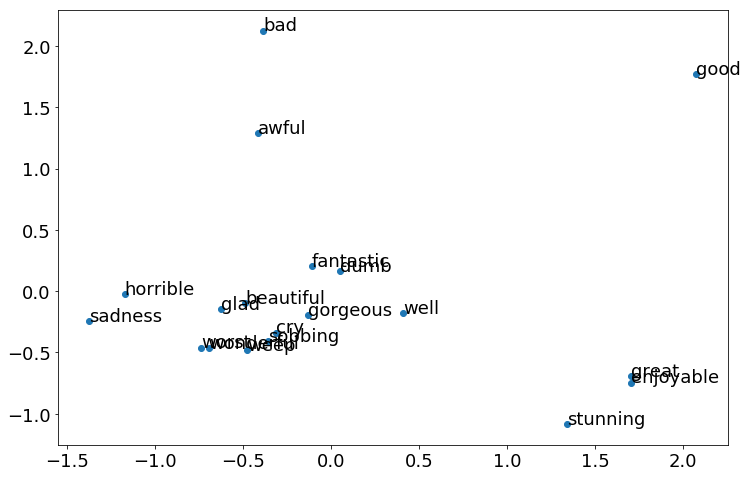

After


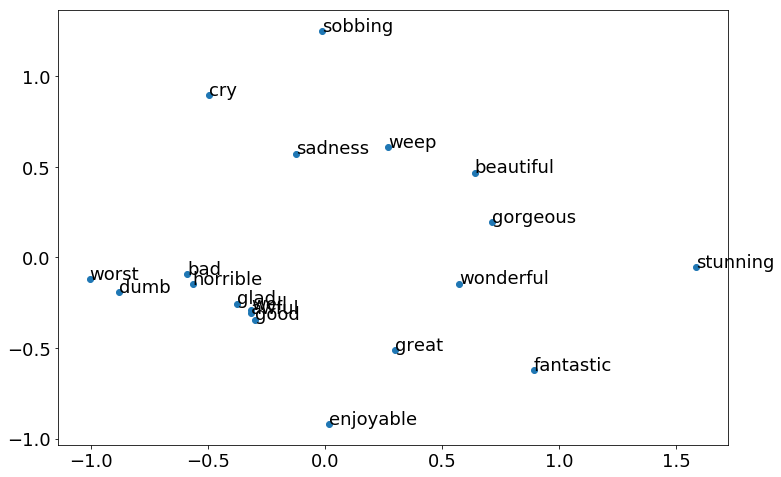

In [13]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, original_embeddings, original_word_dict)
print("After")
draw_plot(words, final_embeddings, word_dict)

# Plot loss/epoch and acc/epoch

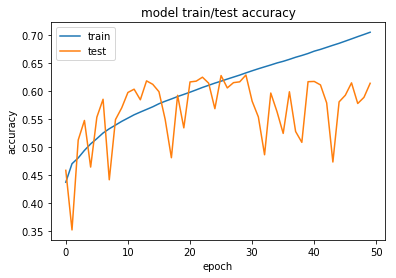

In [342]:
import matplotlib.pyplot as plt

# summarize history for accuracy  
plt.plot(train_accuracy_list)  
plt.plot(test_accuracy_list)  
plt.title('model train/test accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig('train_test_accuracy.png')


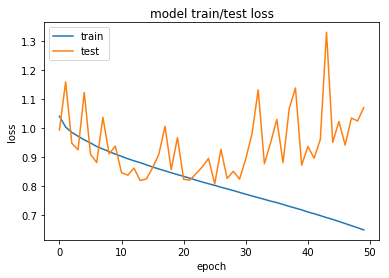

In [343]:
# summarize history for loss  
plt.plot(train_loss_list)  
plt.plot(test_loss_list)  
plt.title('model train/test loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig('train_test_loss.png')